1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df=pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv', index_col=0)

df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [3]:
df=df.replace("No",0).replace("Yes",1)
df.head()

,default,student,balance,income
1,0,0,729.526495,44361.625074
2,0,1,817.180407,12106.134700
3,0,0,1073.549164,31767.138947
4,0,0,529.250605,35704.493935
5,0,0,785.655883,38463.495879


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

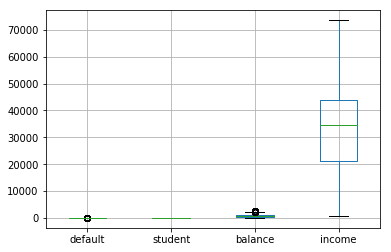

In [4]:
df.boxplot()

Text(0,0.5,'Income')

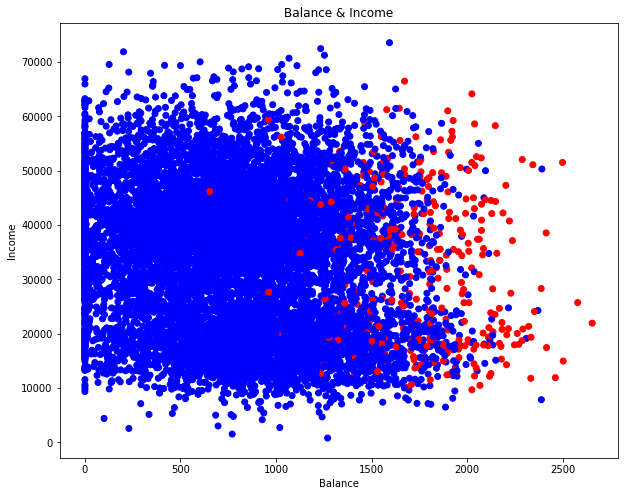

In [4]:
colors=df["default"]
colors=colors.replace(1,"r").replace(0,"b")

plt.figure(figsize=(10,8))
plt.scatter(df['balance'],df['income'],c=colors)
plt.title("Balance & Income")
plt.xlabel("Balance")
plt.ylabel("Income")

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

(-2.735857787197079, 3.282667354750051)

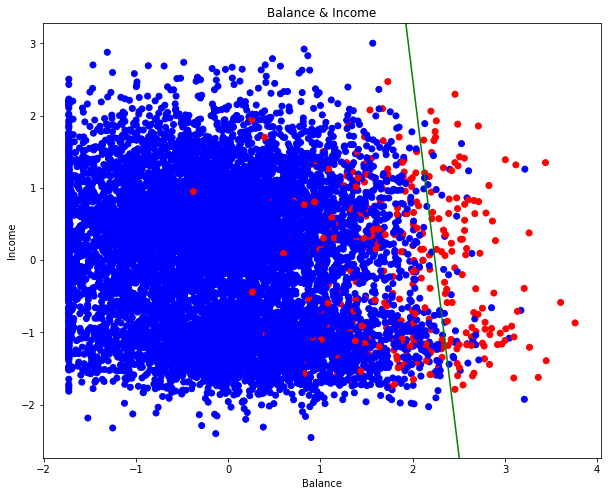

In [5]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

#split data
X = df[["balance","income"]]
y = df["default"]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

#train data
lr = LogisticRegression(penalty='l1')
lr.fit(X_train, y_train)

#scatter plot
colors={0:'b', 1:'r'}
fig,ax = plt.subplots(figsize=(10,8))

ax.scatter(X[:,0],X[:,1], c = df["default"].apply(lambda x:colors[x]))
plt.title("Balance & Income")
plt.xlabel("Balance")
plt.ylabel("Income")

#decision boundary
coef=lr.coef_
a=coef[0]
b=lr.intercept_

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()

x = np.arange(x_min, x_max, 1)
y = (b+a[0]*x)/-a[1]

plt.plot(x, y,c='g')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)


Area under the ROC curve : 0.942674


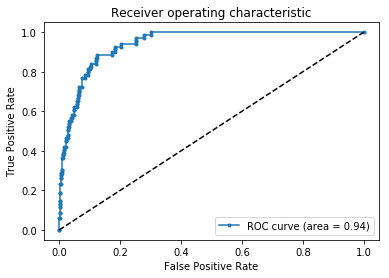

In [6]:
from sklearn.datasets import make_classification

X=df[['balance','income']]
y=df['default']

def generate_auc(X, y, clf_class,**kwargs):
    
    random_state = np.random.RandomState(0)
    classifier = clf_class(**kwargs)
    probas_=classifier.fit(X_train, y_train).predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:,1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, thresholds

#Generate ROC for LR with l1 penalty and C=0.1
fpr,tpr,roc_auc,thresholds = generate_auc(X,y,LogisticRegression, C=0.1, penalty='l1')
def generate_ROCplot(fpr, tpr, label, roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-', label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

# plot ROC
generate_ROCplot(fpr,tpr,'LR',roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

Area under the ROC curve : 0.943545
The performance after add one variable is not significantly increased 
The coefficients for balance, income and student are respectively: [ 0.06434194  0.00306679 -0.00280049]


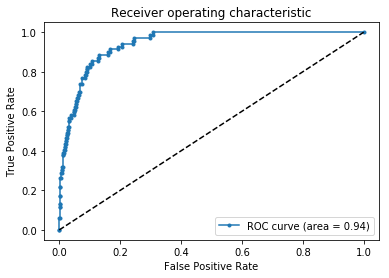

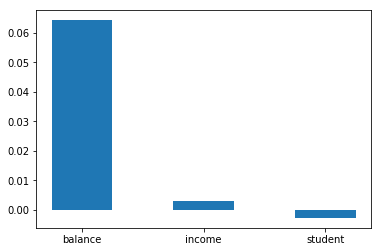

In [7]:
from sklearn.linear_model import Ridge

X = df[["balance","income","student"]]
y = df["default"]

#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

fpr,tpr,roc_auc, thresholds = generate_auc(X,y,LogisticRegression,C=0.1,penalty='l1')
generate_ROCplot(fpr,tpr,'LR',roc_auc)

alphas = np.logspace(-6, -1, 100)
score = []
for alpha in alphas:
    clf = Ridge(alpha=alpha)
    clf.fit(X_train, y_train)
    score.append(clf.score(X_test, y_test))
opt_index = np.array(score).argmax()

clf = Ridge(alpha=alphas[opt_index])
clf.fit(X_train, y_train)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.bar(np.arange(3), clf.coef_, 0.5)
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('balance', 'income', 'student'))
rects = ax.patches
print("The performance after add one variable is not significantly increased ")
print ('The coefficients for balance, income and student are respectively:', clf.coef_)
plt.show()

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

In [8]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, X_train, y_train, cv=5)
print(scores)
print("Judgeing from cross valdiation score, my model is robust.")

[0.97688944 0.973125   0.973125   0.970625   0.97811132]
Judgeing from cross valdiation score, my model is robust.


7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

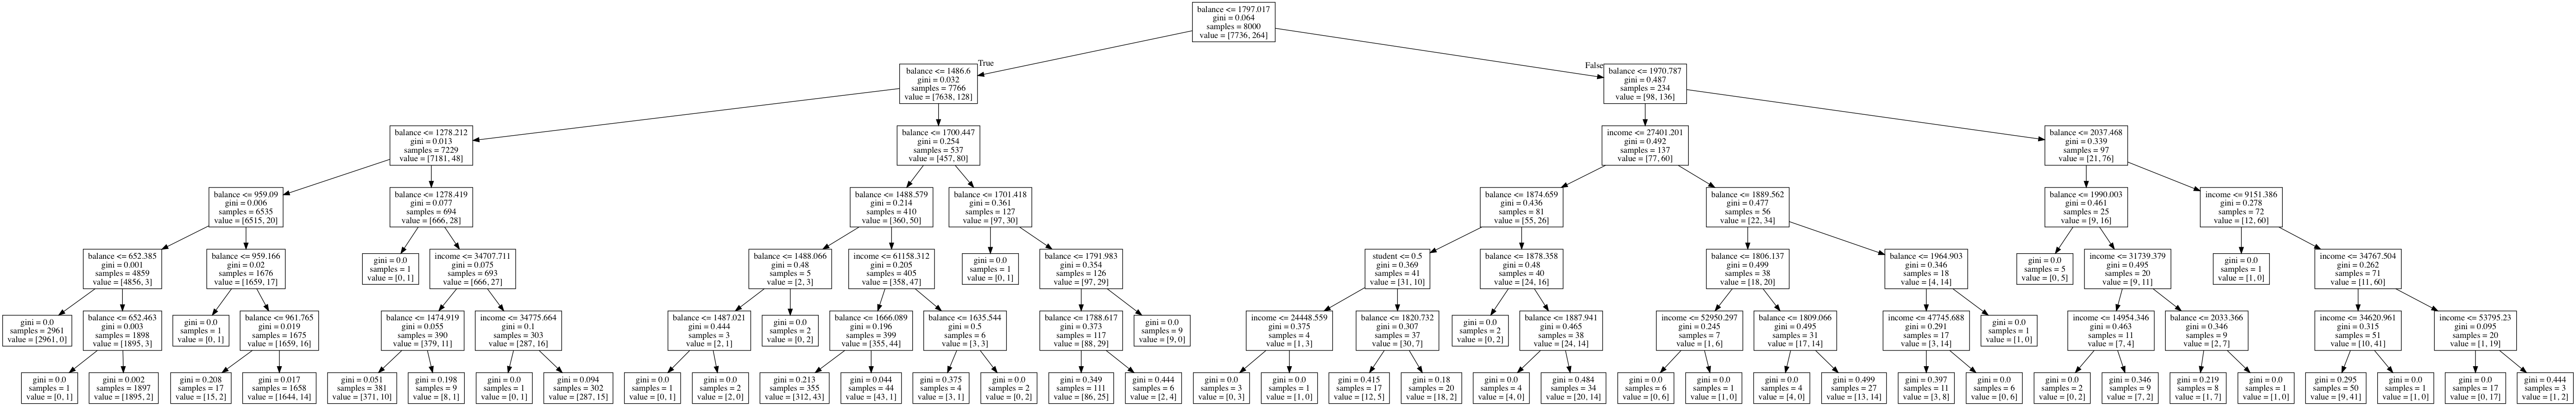

In [10]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus
X = df.drop(["default"],1)
y = df.default
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42)

dt=DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

dot_data = StringIO()  
export_graphviz(dt, out_file=dot_data, feature_names=X_train.columns)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC. 

Optimal Depth: 5.


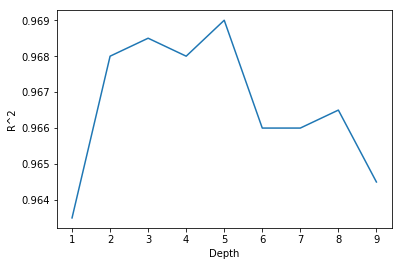

In [11]:
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,10)
for n in depths:
    dt = DecisionTreeClassifier(max_depth=n)
    # Train the model using the training sets
    dt.fit(X_train, y_train)
    train_errors.append(dt.score(X_train,y_train))
    scores.append(dt.score(X_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.plot(depths,scores)
test_errors = scores
n_opt = depths[np.argmax(scores)]
print("Optimal Depth: {0}.".format(n_opt))
plt.show()


Area under the ROC curve : 0.932550
Max Depth = 4
Area under the ROC curve : 0.921757
Max Depth = 5
Area under the ROC curve : 0.904683
Max Depth = 6
According to ROC figures, the depth of 4 seems a little bit better than the depth of 5.


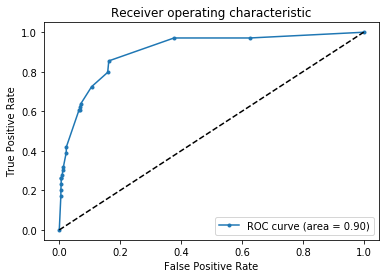

In [14]:
# Different Max Depth = 4
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 4)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 4')

# Different Max Depth = 5
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 5)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 5')

# Different Max Depth = 6
fpr,tpr,roc_auc, thresholds = generate_auc(X,y,DecisionTreeClassifier,max_depth = 6)
generate_ROCplot(fpr,tpr,'LR',roc_auc)
print('Max Depth = 6')

print('According to ROC figures, the depth of 4 seems a little bit better than the depth of 5.')
